In [1]:
import pandas as pd

In [2]:
interventions = pd.read_csv('interventions_belgium_full_id.csv')

In [10]:
count = interventions[interventions['waiting_time'] > 15].shape[0]
print(count)
proportion = count / interventions.shape[0]
print(proportion)


184118
0.24349465977559948


## Selected cases where waiting time is more than 15 mins (I assume it's in minutes idk really)

In [11]:
interventions = interventions.drop_duplicates()
interventions = interventions.loc[interventions['waiting_time'] > 15]


In [23]:
interventions = interventions[interventions['AED need level'] > 1]
interventions = interventions.dropna()
interventions

mission_id  waiting_time  Latitude intervention  \
18      1.022152e+10          26.0               51.23266   
22      1.022152e+10          18.0               51.16376   
30      1.022152e+10          17.0               51.25461   
31      1.022152e+10          20.0               51.17087   
38      1.022152e+10          16.0               51.42894   
...              ...           ...                    ...   
717382  2.023151e+10          18.0               50.86008   
717416  2.023151e+10          16.0               50.84737   
717439  2.023151e+10          39.0               50.85906   
717448  2.023151e+10          27.0               50.82887   
717454  2.023151e+10          24.0               50.84592   

        Longitude intervention           EventType Firstcall  AED need level  
18                     4.44440             P011 - Chest pain               2  
22                     4.98392             P011 - Chest pain               2  
30                     4.49728             P011 - Chest pain               2  
31                     4.71213  P019 - Unconscious - syncope               2  
38                     4.50414             P011 - Chest pain               2  
...                        ...                           ...             ...  
717382                 4.36533   P010 - Respiratory problems               2  
717416                 4.41038  P019 - Unconscious - syncope               2  
717439                 4.30053   P010 - Respiratory problems               2  
717448                 4.39021  P019 - Unconscious - syncope               2  
717454                 4.29723   P010 - Respiratory problems               2  

[41992 rows x 6 columns]

In [24]:
from sklearn.cluster import KMeans

In [36]:
import matplotlib.pyplot as plt

In [31]:
points = interventions[['Latitude intervention', 'Longitude intervention']].values

In [34]:
from tqdm import tqdm
max_clusters = 100
wcss = []
for i in tqdm(range(1, max_clusters + 1)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(points)
    wcss.append(kmeans.inertia_)
    

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


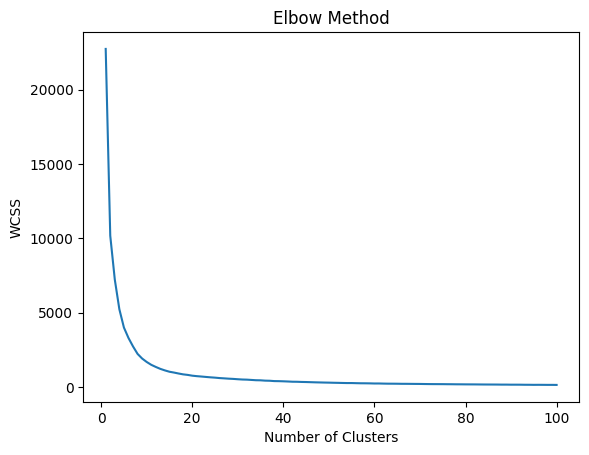

In [37]:
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [38]:
optimal_num_clusters = 1
for i in range(1, len(wcss) - 1):
    slope_current = wcss[i] - wcss[i - 1]
    slope_next = wcss[i + 1] - wcss[i]
    if slope_current > 0 and slope_next < 0:
        optimal_num_clusters = i + 1
        break

In [39]:
optimal_num_clusters

55

In [40]:
kmeans = KMeans(n_clusters=optimal_num_clusters)

In [41]:
kmeans.fit(points)

KMeans(n_clusters=55)

In [43]:
interventions['Cluster'] = kmeans.labels_

In [44]:
interventions['Cluster']

18        18
22        14
30        30
31        48
38        30
          ..
717382    50
717416    50
717439     5
717448    50
717454     5
Name: Cluster, Length: 41992, dtype: int32

In [45]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Latitude', 'Longitude'])
cluster_centers['Cluster'] = range(optimal_num_clusters)

In [46]:
interventions.to_csv('interventions_clustered.csv', index=False)

In [47]:
cluster_centers.to_csv('cluster_centers.csv', index=False)

In [48]:
import plotly.express as px
import plotly.graph_objects as go

In [53]:
fig = px.scatter_mapbox(interventions, lat='Latitude intervention', lon='Longitude intervention', color='Cluster',
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=6, center={'lat': 50.6, 'lon': 4.35})
fig.update_layout(mapbox_style="open-street-map")

for i in range(optimal_num_clusters):
    cluster_points = interventions[interventions['Cluster'] == i]
    fig.add_trace(go.Scattermapbox(
        mode="markers+lines",
        lon=cluster_points['Longitude intervention'],
        lat=cluster_points['Latitude intervention'],
        marker={'size': 15, 'color': 'black'},
        text=cluster_points['Cluster'].astype(str),
        name=f"Zone {i+1}",
        hoverinfo='text',
        visible= False
    ))
    
fig.update_layout(title="Interventions with possible AED zones")
fig.show()

In [54]:
fig.write_html("clusters_map.html")